The following piece of code extracts raw data and replaces missing values with zeros. Particular missing data patterns may distribute unevenly in the dataset.
For example, the label 8 instances normally include P0 input, while label 0 events usually don't. This procedure saves absolute values of pressure and temperature. Signal noise feature is also available. It should be noted that   the dataset comprising instances of raw sensor readings, simulated data, and digitized hand-written inputs can be distinguished from one another by signal noise characteristics. The CAD-obtained and handwritten samples comprise smooth time series while the real data instances have a significant signal noise.

In [3]:
import csv
import numpy as np
import os
import matplotlib.pyplot as plt

dataset=[]
labels=[]
timewindow=10 # timesteps used for making an instance
rawdata = os.scandir('../input/3w-dataset/3W/')
c=0

for entry in rawdata:
    group=os.scandir('../input/3w-dataset/3W/'+entry.name)
    foldername='../input/3w-dataset/3W/'+entry.name
    for entry in group:
        dataset.append(foldername+'/'+entry.name)
        labels.append(c)
    c+=1
print(len(labels))

def img(a): #function to process extracted raw data
    B=np.zeros((timewindow))
    maxV=max(a)
    if maxV>0:
        B=np.asarray(a)
    return(B)

i=0 #extracting raw data
for row in dataset:
    n=dataset[i]
    with  open(n, newline='') as f:
        reader = csv.reader(f)
        p0,p1,t1,p2,t2=[],[],[],[],[]
        ii=0
        for row in reader:      
            ii+=1
            if ii>1 and ii<= timewindow +1:                
                try:
                    p0.append(float(row[1])) 
                except ValueError:
                    p0.append(0) 
                try:
                    p1.append(float(row[2])) 
                except ValueError:
                    p1.append(0) 
                try:
                    t1.append(float(row[3])) 
                except ValueError:
                    t1.append(0)
                try:
                    p2.append(float(row[4])) 
                except ValueError:
                    p2.append(0) 
                try:
                    t2.append(float(row[5])) 
                except ValueError:
                    t2.append(0) 
        Str=np.concatenate([[labels[i]],img(p0),img(p1),img(t1),img(p2),img(t2)])
        if i==0:
                rez=Str  
        else:
                rez=np.vstack((rez,Str))
    i+=1

np.savetxt("1.csv",rez, delimiter=",")

1984


In the code above, with the parameter "timewindow" set to 10 we extract first 10 recodrings of sensors' data that contain a neglicable amount of information about the events they are related to. It is worth suggestng, the features that are extracted in the proposed way may be misleading for a classifier and result in a biased output. To find it out, we deploy an NN with the following simplistic design:

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p0 (InputLayer)                 [(None, 10)]         0                                            
__________________________________________________________________________________________________
p1 (InputLayer)                 [(None, 10)]         0                                            
__________________________________________________________________________________________________
t1 (InputLayer)                 [(None, 10)]         0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 10)]         0                                            
____________________________________________________________________________________________

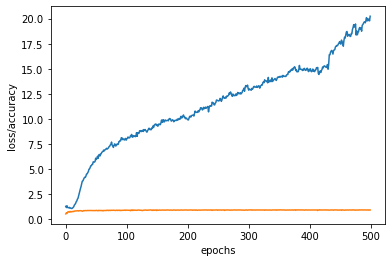

In [8]:
import numpy as np
import csv

dataset=[]
with open(r'./1.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dataset.append(row)
    
np.array(dataset,dtype=np.float32)
np.random.shuffle(dataset)

np.savetxt('data1.csv', dataset, fmt='%s',delimiter=',')

from  tensorflow import keras
from tensorflow.keras import layers
from  tensorflow import math


x=10 #size of sample in timesteps
datast=[]
with open(r'./data1.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        datast.append(row)
        
dataset=np.asarray(datast,dtype=float)
labels,p0,p1,t1,p2,t2=np.hsplit(dataset,[1,x+1,2*x+1,3*x+1,4*x+1])
label=labels.flatten()
p0,p1,t1,p2,t2= p0/np.max(p0), p1/np.max(p1), t1/np.max(t1), p2/np.max(p2), t2/np.max(t2) # here we rescale features with the dataset global maximum values, hence, absolute value feature is still preserved
p0_data=keras.Input(shape=(x,), name='p0')
p1_data=keras.Input(shape=(x,), name='p1')
t1_data=keras.Input(shape=(x,), name='t1')
p2_data=keras.Input(shape=(x,), name='p2')
t2_data=keras.Input(shape=(x,), name='t2')

x1=layers.Dense(4*x, activation="relu", use_bias=False)(p0_data)
x2=layers.Dense(4*x, activation="relu", use_bias=False)(p1_data)
x3=layers.Dense(4*x, activation="relu", use_bias=False)(t1_data)
x4=layers.Dense(4*x, activation="relu", use_bias=False)(p2_data)
x5=layers.Dense(4*x, activation="relu", use_bias=False)(t2_data)

xx=layers.concatenate([x1,x2,x3,x4,x5])

xx=layers.Dense(10*x,activation="relu", use_bias=False)(xx)

catN=layers.Dense(9,activation="softmax", use_bias=False, name='output')(xx)

model = keras.Model(inputs=[p0_data,p1_data,t1_data,p2_data,t2_data], outputs=catN)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=opt,  metrics=[keras.metrics.SparseCategoricalAccuracy()])
history = model.fit({'p0':p0,'p1':p1, 't1':t1, 'p2':p2,'t2':t2},{'output':label}, 
          epochs=500, validation_split=0.5)

plt.plot(history.history['val_loss'], label='loss')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='accuracy')
plt.xlabel('epochs')
plt.ylabel('loss/accuracy')
plt.savefig('metrics1.png')

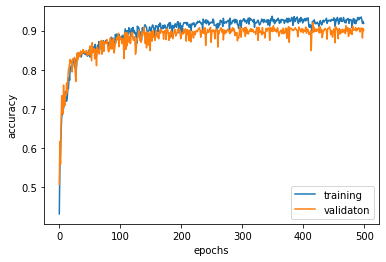

In [9]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training', 'validaton'])
plt.savefig('metrics1.png')

In [10]:
dataset=[]
labels=[]

pr=500# timesteps prior to event starting point
af=500# timesteps after event starting point
m=700 #size of sample in timesteps
slide=100
timewindow=pr+af
rawdata = os.scandir('../input/3w-dataset/3W/')
c=0

for entry in rawdata:
    group=os.scandir('../input/3w-dataset/3W/'+entry.name)
    foldername='../input/3w-dataset/3W/'+entry.name
    for entry in group:
        dataset.append(foldername+'/'+entry.name)
        labels.append(c)
    c+=1


def img(a):
    A=np.zeros((m+1))
    for i in range(4): # cycle for extracting  4 samples from timewindow
        startP=i*100
        if i==0:
            A=a[startP:startP+m]
            maxV=max(A)
            minV=min(A)
            d=maxV-minV
            for j in range(m):
                A[j]=(A[j]-minV)/d # erasing absolute value feature by rescaling
            A.append(d/maxV) # adding scale coefficient sv
        else:
            B=a[startP:startP+m]
            maxV=max(B)
            minV=min(B)
            d=maxV-minV
            for j in range(m):
                B[j]=(B[j]-minV)/d# erasing absolute value feature by rescaling
            B.append(d/maxV) # adding scale coefficient sv
            A=np.vstack((A,B))
    return(A)


i=0
for row in dataset:
    n=dataset[i]
    with  open(n, newline='') as f:
        reader = csv.reader(f)
        p0,p1,t1,p2,t2,pd=[],[],[],[],[],[]
        p00,p01,t01,p02,t02,pd=[],[],[],[],[],[]
        ii=0
        state=1 # flag that subsequently changes its value at event’s starting point to the corresponding ii value
        for row in reader:
            ii+=1
            if ii>1 and state>0:                
                p00.append(1) if float(row[1]+'0')<=0 else p00.append(0)
                p01.append(1) if float(row[2]+'0')<=0 else p01.append(0)
                t01.append(1) if float(row[3]+'0')<=0 else t01.append(0) 
                p02.append(1) if float(row[4]+'0')<=0 else p02.append(0)
                t02.append(1) if float(row[5]+'0')<=0 else t02.append(0)              
                p0.append(float(row[1])*(1+(np.random.sample()*1-1)/100)) if row[1]!='' else p0.append('NaN') # erasing signal #noise feature by adding random noise
                p1.append(float(row[2])*(1+(np.random.sample()*1-1)/100)) if row[2]!='' else p1.append('NaN') # erasing signal #noise feature by adding random noise
                t1.append(float(row[3])*(1+(np.random.sample()*1-1)/100)) if row[3]!='' else t1.append('NaN') # erasing signal #noise feature by adding random noise
                p2.append(float(row[4])*(1+(np.random.sample()*1-1)/100)) if row[4]!='' else p2.append('NaN') # erasing signal #noise feature by adding random noise
                t2.append(float(row[5])*(1+(np.random.sample()*1-1)/100)) if row[5]!='' else t2.append('NaN')     # erasing signal #noise feature by adding random noise          
                if float('0'+row[9])>100 and state==1: state=ii #locating event’s starting point in instance ( inner labeling of #timesteps is in the last column)
                if ii-state>=(af-1) and state>1: state=0
        if pr+af<=len(p0): #cropping raw data and centering the  starting  point. If an instance doesn’t include the starting point #(classes 4 and 5) then the last 1000 timesteps of the instance are extracted 
            del p0[:-(pr+af)]
            del p1[:-(pr+af)]
            del t1[:-(pr+af)]
            del p2[:-(pr+af)]
            del t2[:-(pr+af)]
            del p00[:-(pr+af)]
            del p01[:-(pr+af)]
            del t01[:-(pr+af)]
            del p02[:-(pr+af)]
            del t02[:-(pr+af)]
            p0s=sum(p00)
            p1s=sum(p01)
            t1s=sum(t01)
            p2s=sum(p02)
            t2s=sum(t02)
            if p1s==0 and p2s==0 and t2s==0: # erasing missing data pattern feature by deleting p0, t1 from samples and deleting samples with missing data p1,p2, and t2 
                Str=np.hstack([[[labels[i]],[labels[i]],[labels[i]],[labels[i]]],img(p1),img(p2),img(t2),[[1],[2],[3],[4]]])
                if i==0:
                    rez=Str  
                else:
                    rez=np.vstack((rez,Str))
    i+=1

np.savetxt("2.csv",rez, delimiter=",")

The above procedure cleans the raw data from the irrelevant features  and extracts samples from the original instances  as described by the following picture ( normal, transcient and faulty regimes are defined according to  labeling of sensor data)


![image.png](attachment:86180d8c-aa4b-4b7f-94db-9cf9fe0b48b0.png)

 
If we apply the same feature cleansing to the instances of the previous NN input, we obtain 30.37% accuracy that is the desirable result

In [11]:
dataset=[]
with open(r'./2.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dataset.append(row)
    
np.array(dataset,dtype=np.float32)
np.random.shuffle(dataset)

np.savetxt('data2.csv', dataset, fmt='%s',delimiter=',')

vs=0.5
x=700# size of sample in timesteps
dst=[]
with open(r'./data2.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dst.append(row)
        
dataset=np.asarray(dst,dtype=float)
label,p1,ts1,p2,ts2,t2,ts3,interlabel=np.hsplit(dataset,[1,x+1,x+2,2*x+2,2*x+3,3*x+3,3*x+4])# interlabel is a sample’s parameter showing its position in the time window. This parameter equals to 1,2,3, or 4 and is isolated from the NN’s input
label=label.flatten()

sc=np.concatenate([ts1,ts2,ts3],axis=1) # forming vector of scale factors

p1_=keras.Input(shape=(x,), name='p1')
p2_=keras.Input(shape=(x,), name='p2')
t2_=keras.Input(shape=(x,), name='t2')
sc_=keras.Input(shape=(3,), name='sc')

sc_00=layers.Reshape((1,3))(sc_)
sc_00=layers.UpSampling1D(size=int(x/35))(sc_00)

p1_00=layers.Reshape((x,1))(p1_)
p2_00=layers.Reshape((x,1))(p2_)
t2_00=layers.Reshape((x,1))(t2_)

p1_0=layers.MaxPooling1D(pool_size=35,strides=None)(p1_00)
p2_0=layers.MaxPooling1D(pool_size=35,strides=None)(p2_00)
t2_0=layers.MaxPooling1D(pool_size=35,strides=None)(t2_00)

p1_1=layers.AveragePooling1D(pool_size=35,strides=None)(p1_00)
p2_1=layers.AveragePooling1D(pool_size=35,strides=None)(p2_00)
t2_1=layers.AveragePooling1D(pool_size=35,strides=None)(t2_00)

pt=layers.concatenate([p1_0,p1_1,p2_0,p2_1,t2_0,t2_1,sc_00],axis=2)

pt =layers.Conv1D(
    64,
    3,
    strides=1,
    padding="valid",
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    )(pt)

pt =layers.MaxPooling1D(pool_size=3,strides=3)(pt)

pt =layers.LSTM(
    30,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.6,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,)(pt)

pt =layers.Dense(27,activation="relu", use_bias=True)(pt)
catN=layers.Dense(9,activation="softmax", use_bias=False, name='output')(pt)

model = keras.Model(inputs=[p1_,p2_,t2_,sc_], outputs=catN)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=opt,  metrics=[keras.metrics.SparseCategoricalAccuracy()])
fitting=model.fit({'p1':p1,'p2':p2,'t2':t2,'sc':sc},{'output':label}, 
          epochs=500, validation_split=vs)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p1 (InputLayer)                 [(None, 700)]        0                                            
__________________________________________________________________________________________________
p2 (InputLayer)                 [(None, 700)]        0                                            
__________________________________________________________________________________________________
t2 (InputLayer)                 [(None, 700)]        0                                            
__________________________________________________________________________________________________
sc (InputLayer)                 [(None, 3)]          0                                            
____________________________________________________________________________________________

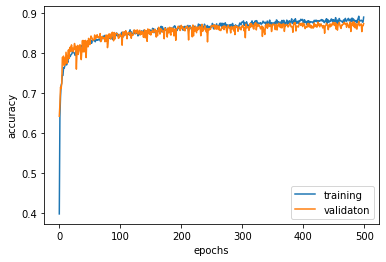

In [13]:
plt.plot(fitting.history['sparse_categorical_accuracy'])
plt.plot(fitting.history['val_sparse_categorical_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training', 'validaton'])
plt.savefig('metrics2.png')

With the obtained resampled and cleansed dataset we trained the LSTM neural network  achieving 89% accuracy.  The results of numerical experiments using this network demonstrate that the algorithm shows the maximum performance when trained with samples  that include  at least 300 seconds prior the starting point of an identified event.

![image.png](attachment:cd1e09f4-9a5a-4912-81ea-ac8cd22e87f8.png)
![image.png](attachment:1dc766af-d9b0-47c0-b4e7-5a047d07eb0a.png)

In [14]:
model.save('iteration1.keras')